In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import chip8 as mp
import chip8_vec as vec
import chip8_vec2 as vec2
import chip8_vec_th as vec_th
import chip8_vec_th2 as vec_th2
import chip8_vec_jax as vec_jax
import chip8_vec_cp as vec_cp
import chip8_vec_cp2 as vec_cp2


plt.rcParams["figure.figsize"] = [20, 8]
sns.set_theme()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
game = "games/pong_1p.ch8"
modules = [
    # "mp",
    "vec",
    "vec2",
    # "pytorch_cpu",
    # "pytorch_gpu",
    "pytorch2_cpu",
    "pytorch2_gpu",
    # "jax",
    # "cupy",
    "cupy2",
]
max_cycles = 1_000

df = pd.DataFrame(
    columns=[
        "module",
        "n_emulators",
        "n_frames",
        "time",
        "effective_fps",
    ]
)

for module in modules:
    if module == "mp":
        main = mp.main_multiprocessing
    elif module == "vec":
        main = vec.main
    elif module == "vec2":
        main = vec2.main
    elif module == "pytorch_cpu":
        main = vec_th.main
        device = "cpu"
    elif module == "pytorch_gpu":
        main = vec_th.main
        device = "cuda"
    elif module == "pytorch2_cpu":
        main = vec_th2.main
        device = "cpu"
    elif module == "pytorch2_gpu":
        main = vec_th2.main
        device = "cuda"
    elif module == "jax":
        main = vec_jax.main
    elif module == "cupy":
        main = vec_cp.main
    elif module == "cupy2":
        main = vec_cp2.main

    keep_running = True
    last_fps = 0
    n_emulators = 1
    pbar = tqdm(desc=module)
    while keep_running:
        if module.startswith("pytorch"):
            dt = main(
                game,
                n_emulators=n_emulators,
                max_cycles=max_cycles,
                device=device,
            )
        else:
            dt = main(game, n_emulators=n_emulators, max_cycles=max_cycles)
        effective_fps = n_emulators * (max_cycles // 8) / dt
        new_row = pd.DataFrame(
            [
                {
                    "module": module,
                    "n_emulators": n_emulators,
                    "n_frames": max_cycles // 8,
                    "time": dt,
                    "effective_fps": effective_fps,
                }
            ]
        )
        df = (
            new_row
            if df.empty
            else pd.concat([df, new_row], ignore_index=True)
        )
        if effective_fps < last_fps:
            keep_running = False
        last_fps = effective_fps
        n_emulators *= 2
        pbar.update(1)
    pbar.close()
df

vec: 16it [00:06,  2.46it/s]
vec2: 16it [00:08,  2.00it/s]
pytorch2_cpu: 18it [00:24,  1.38s/it]
pytorch2_gpu: 18it [00:30,  1.71s/it]
cupy2: 19it [01:27,  4.61s/it]


,module,n_emulators,n_frames,time,effective_fps
0,vec,1,125,0.139643,8.951366e+02
1,vec,2,125,0.122923,2.033796e+03
2,vec,4,125,0.122544,4.080162e+03
3,vec,8,125,0.123254,8.113337e+03
4,vec,16,125,0.127712,1.566024e+04
...,...,...,...,...,...
82,cupy2,16384,125,3.751532,5.459103e+05
83,cupy2,32768,125,3.861704,1.060672e+06
84,cupy2,65536,125,5.124004,1.598750e+06
85,cupy2,131072,125,8.516041,1.923899e+06


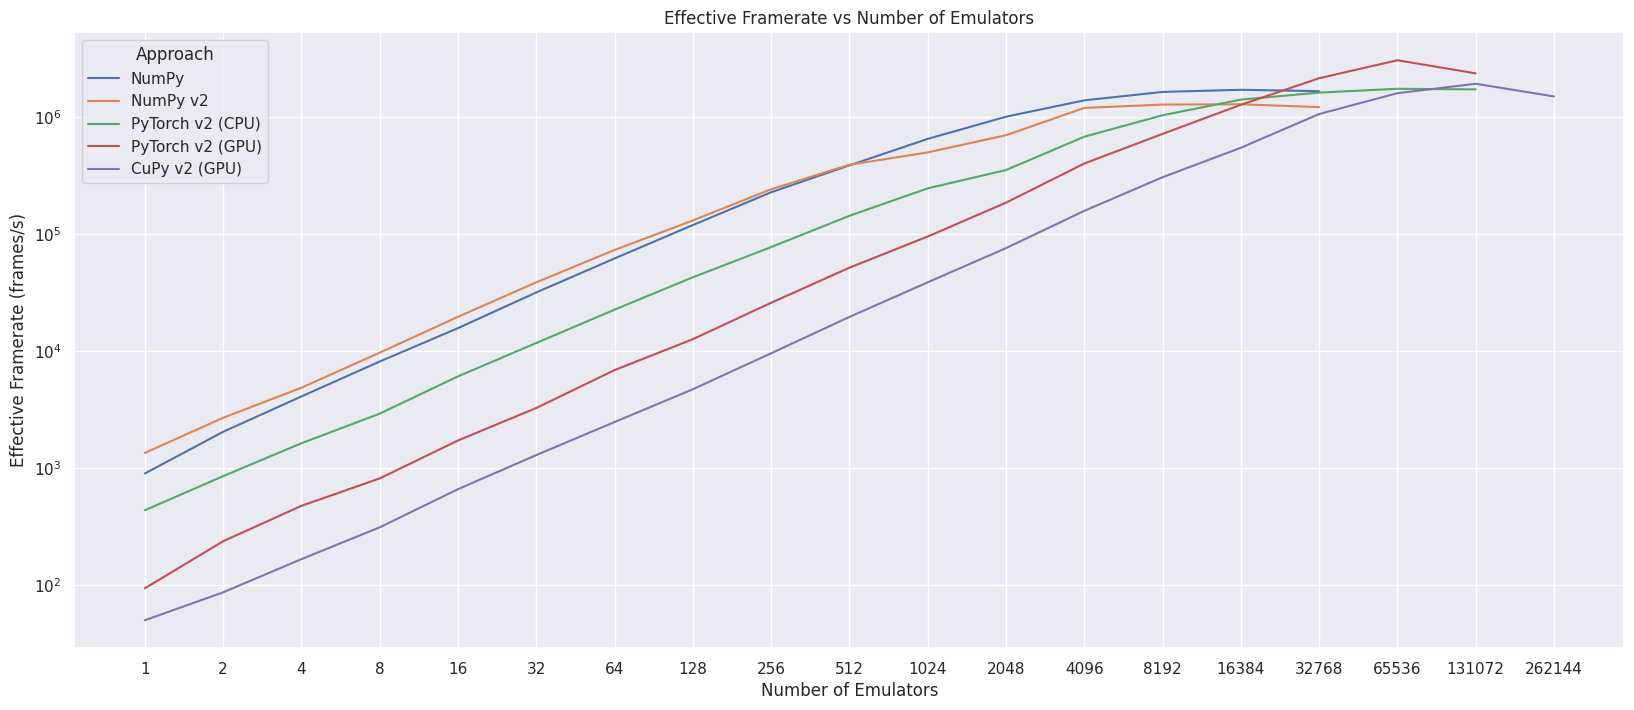

In [7]:
df["approach"] = df["module"].replace(
    {
        "mp": "Multiprocessing",
        "vec": "NumPy",
        "vec2": "NumPy v2",
        "pytorch_cpu": "PyTorch (CPU)",
        "pytorch_gpu": "PyTorch (GPU)",
        "pytorch2_cpu": "PyTorch v2 (CPU)",
        "pytorch2_gpu": "PyTorch v2 (GPU)",
        "jax": "JAX (GPU)",
        "cupy": "CuPy (GPU)",
        "cupy2": "CuPy v2 (GPU)",
    }
)

ax = sns.lineplot(data=df, x="n_emulators", y="effective_fps", hue="approach")
ax.set_yscale("log")
ax.set_xscale("log")
xticks = [2**i for i in range(int(np.log2(df["n_emulators"].max())) + 1)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(title="Approach", loc="upper left")

plt.xlabel("Number of Emulators")
plt.ylabel("Effective Framerate (frames/s)")
plt.title("Effective Framerate vs Number of Emulators")
plt.show()